http://www.pnas.org/content/93/19/10078.long

Import packages

In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import rc

#for latex-rendering. (I guess with a lot of redundancy.. but it works!)
rc('text', usetex=True) #
plt.rcParams['text.usetex'] = True #this line turns "ticks" on axis into latex  (i think is it the same function as the line above. not sure. )
plt.rcParams['text.latex.unicode'] = True 
#for the size of the exported figures
plt.rcParams['figure.figsize'] = (24, 18)
rc('text.latex', preamble=r'\usepackage{cmbright}')#this line turns text in legends for instance into latex

In [35]:
def round_to_n(x, n):
    " Round x to n significant figures "
    return round(x, -int(math.floor(np.sign(x) * math.log10(abs(x)))) + n)

def str_fmt(x, n=2):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"${} \, 10^{{ {} }}$".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)
    
def str_fmt_round_numb(x, n=1):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        power = int(np.log10(round_to_n(x, 0)))-1
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)

def str_fmt_name_fig(x, n=2):
    " Format x into nice text - rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"{}*10({})".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"{}*10^({ })".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"{}*10^({ })".format(f_SF, power)
    else:
        return r"{}$".format(x)
    


Choose values for parameters

In [20]:
scale = 1

tmax = 30
tmaxLONG = 1000
 

#(* mean value for the parameters *)
WTV = 0.0023*scale
#(* small to have a small input in the cascade, cf Ferrell.. *)

nnWT = 10

rasgapV = .0002*scale
#(* we vary this paremeter in the code, so this value is not used *)

k11V = 1 #(* randomly chosen *)
k12V = 1

d11V = 1 #(* randomly chosen *)
d12V = 1 #(* randomly chosen *)
a11V = 10000/scale #(* randomly chosen *)
a12V = 10000/scale #(* randomly chosen *)
nn = 10

mostotV = .003*scale
mektotV = 1.2*scale #(*1.2*)
mekpasetotV = .0003*scale
mapktotV = 1.2*scale
mapkpasetotV = .12*scale
e2totV = 0.0003*scale


a1V = 1000/scale
a2V = 1000/scale
a3V = 1000/scale #(* for crossing 10 *)
a4V = 1000/scale #(* for crossing 500 *)
a5V = 1000/scale
a6V = 1000/scale
a7V = 1000/scale
a8V = 1000/scale
a9V = 1000/scale
a10V = 1000/scale


d1V = 150 #(* for crossing 15 *)
d2V = 150
d3V = 150
d4V = 150
d5V = 150
d6V = 150
d7V = 150
d8V = 150
d9V = 150
d10V = 150


k1V = 150
k2V = 150
k3V = 150
k4V = 150
k5V = 150
k6V = 150
k7V = 150
k8V = 150
k9V = 150
k10V = 150

Encode equations of the model

In [21]:
var_names = 'mos', 'mose1', 'mosstar', 'mosstare2', 'mek', 'mekmosstar', 'mekstar', 'mekstarmekpase', 'mekstarmosstar', \
    'mekstarstar', 'mekstarstarmekpase', 'mapk', 'mapkmekstarstar', 'mapkstar', \
    'mapkstarmekstarstar', 'mapkstarstar', 'mapkstarmapkpase', \
    'mapkstarstarmapkpase'
    
params_names = 'mostot', 'e2tot', 'mektot', 'mekpasetot', 'mapktot', 'mapkpasetot', \
    'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', \
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', \
    'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10','WT', 'rasgdp', 'WE1', 'WsE2'

def equationsmodel(var, t, params):
    
    mos, mose1, mosstar, mosstare2, mek, mekmosstar, mekstar, mekstarmekpase, mekstarmosstar,\
    mekstarstar,mekstarstarmekpase, mapk, mapkmekstarstar, mapkstar, \
    mapkstarmekstarstar, mapkstarstar, mapkstarmapkpase, \
    mapkstarstarmapkpase = var
    
    mostot, e2tot, mektot, mekpasetot, mapktot, mapkpasetot, \
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, \
    d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, \
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, WT, rasgdp, WE1,WsE2 = params
    
    dmos = -a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*((WT - rasgdp - WE1 - WsE2) - mose1) + d1*mose1 +\
    k2*mosstare2
    
    dmose1 = a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*((WT - rasgdp - WE1 - WsE2) - mose1) -(d1+k1)*mose1
    
    dmosstar = -a2*mosstar*(e2tot - mosstare2) + d2*mosstare2 + k1*mose1 + \
    (k3 + d3)*mekmosstar -  a3*mosstar*(mektot - mekstar - mekstarstar - \
    mekstarmekpase - mekstarstarmekpase - mekmosstar - mekstarmosstar - \
    mapkmekstarstar - mapkstarmekstarstar) + (k5 + d5)* mekstarmosstar - \
    a5*mekstar*mosstar
      
    dmosstare2 = a2*mosstar*(e2tot - mosstare2) - (d2 + k2)*mosstare2
    
    dmek = -a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar + d3*mekmosstar + k4*mekstarmekpase
     
    dmekmosstar = a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar - (d3 + k3)*mekmosstar
    
    dmekstar = -a4*mekstar*(mekpasetot - mekstarmekpase - mekstarstarmekpase)\
    + d4*mekstarmekpase + k3*mekmosstar + k6*mekstarstarmekpase + \
    d5*mekstarmosstar - a5*mekstar*mosstar
    
    dmekstarmekpase = a4*mekstar*(mekpasetot - mekstarmekpase - \
    mekstarstarmekpase)-(d4 + k4)*mekstarmekpase 

    dmekstarmosstar = a5*mekstar*mosstar - (d5 + k5)*mekstarmosstar
    
    dmekstarstar = k5*mekstarmosstar - a6*mekstarstar*(mekpasetot - 
    mekstarmekpase - mekstarstarmekpase) + d6*mekstarstarmekpase - \
    a7*mekstarstar*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar) + \
    (d7 + k7)*mapkmekstarstar + (d9 + k9)*mapkstarmekstarstar - \
    a9*mapkstar*mekstarstar
    
    dmekstarstarmekpase = a6*mekstarstar*(mekpasetot - mekstarmekpase \
    - mekstarstarmekpase) - (d6 + k6)*mekstarstarmekpase
    
    dmapk = -a7*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar \
    + d7*mapkmekstarstar + k8*mapkstarmapkpase
    
    dmapkmekstarstar = a7*(mapktot - mapkstar - mapkstarstar \
    - mapkstarmapkpase - mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar - (d7 + k7)*mapkmekstarstar
    
    dmapkstar = k7*mapkmekstarstar - a8*mapkstar*(mapkpasetot - \
    mapkstarmapkpase - mapkstarstarmapkpase) + d8*mapkstarmapkpase - \
    a9*mapkstar*mekstarstar + d9*mapkstarmekstarstar + k10*mapkstarstarmapkpase
    
    dmapkstarmekstarstar =a9*mapkstar*mekstarstar - (d9 + k9)*mapkstarmekstarstar
    
    dmapkstarstar = -a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) + d10*mapkstarstarmapkpase + k9*mapkstarmekstarstar 
    
    dmapkstarmapkpase = a8*mapkstar*(mapkpasetot - mapkstarmapkpase - 
    mapkstarstarmapkpase) - (d8 + k8)*mapkstarmapkpase
    
    dmapkstarstarmapkpase = a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) - (d10 + k10)*mapkstarstarmapkpase
     
    return [dmos, dmose1,dmosstar,dmosstare2,dmek,dmekmosstar,dmekstar, \
    dmekstarmekpase, dmekstarmosstar, dmekstarstar, dmekstarstarmekpase, \
    dmapk, dmapkmekstarstar, dmapkstar, dmapkstarmekstarstar, dmapkstarstar, \
    dmapkstarmapkpase, dmapkstarstarmapkpase]


In [22]:
param_v  = [mostotV, e2totV, mektotV, mekpasetotV, mapktotV, mapkpasetotV, \
    a1V, a2V, a3V, a4V, a5V, a6V, a7V, a8V, a9V, a10V, \
    d1V, d2V, d3V, d4V, d5V, d6V, d7V, d8V, d9V, d10V, \
    k1V, k2V, k3V, k4V, k5V, k6V, k7V, k8V, k9V, k10V,WTV,e2totV,0,0]

In [23]:
###################################
# INITIAL CONDTIONS
###################################

initialcond = np.zeros(len(var_names))
initialcond[0] = param_v[0]
initialcond[4] = param_v[2]
initialcond[11] = param_v[4]
###################################
# time array & array to store the output for various input levels of sos
###################################

tStop = tmax
tInc = 0.1
t = np.arange(0., tStop, tInc)

print("The initial conditions are {}(0) = {}, {}(0) = {} and {}(0) = {}".format(var_names[0],params_names[0], \
                                                                 var_names[4],params_names[2], \
                                                                 var_names[11],params_names[4]))
len(initialcond)



The initial conditions are mos(0) = mostot, mek(0) = mektot and mapk(0) = mapktot


18

In [27]:
maxn = 10
inputlist=np.logspace(-10, 1, num=maxn)*scale
maxplots=5;
selectedinput=range(1,maxn,divmod(maxn,maxplots)[0])#we plot only n=maxplots plots 
storeoutput=[]
print(params_names[4],param_v[4])

mapktot 1.2


In [47]:
inputlist[0]
range(1)[0]

0

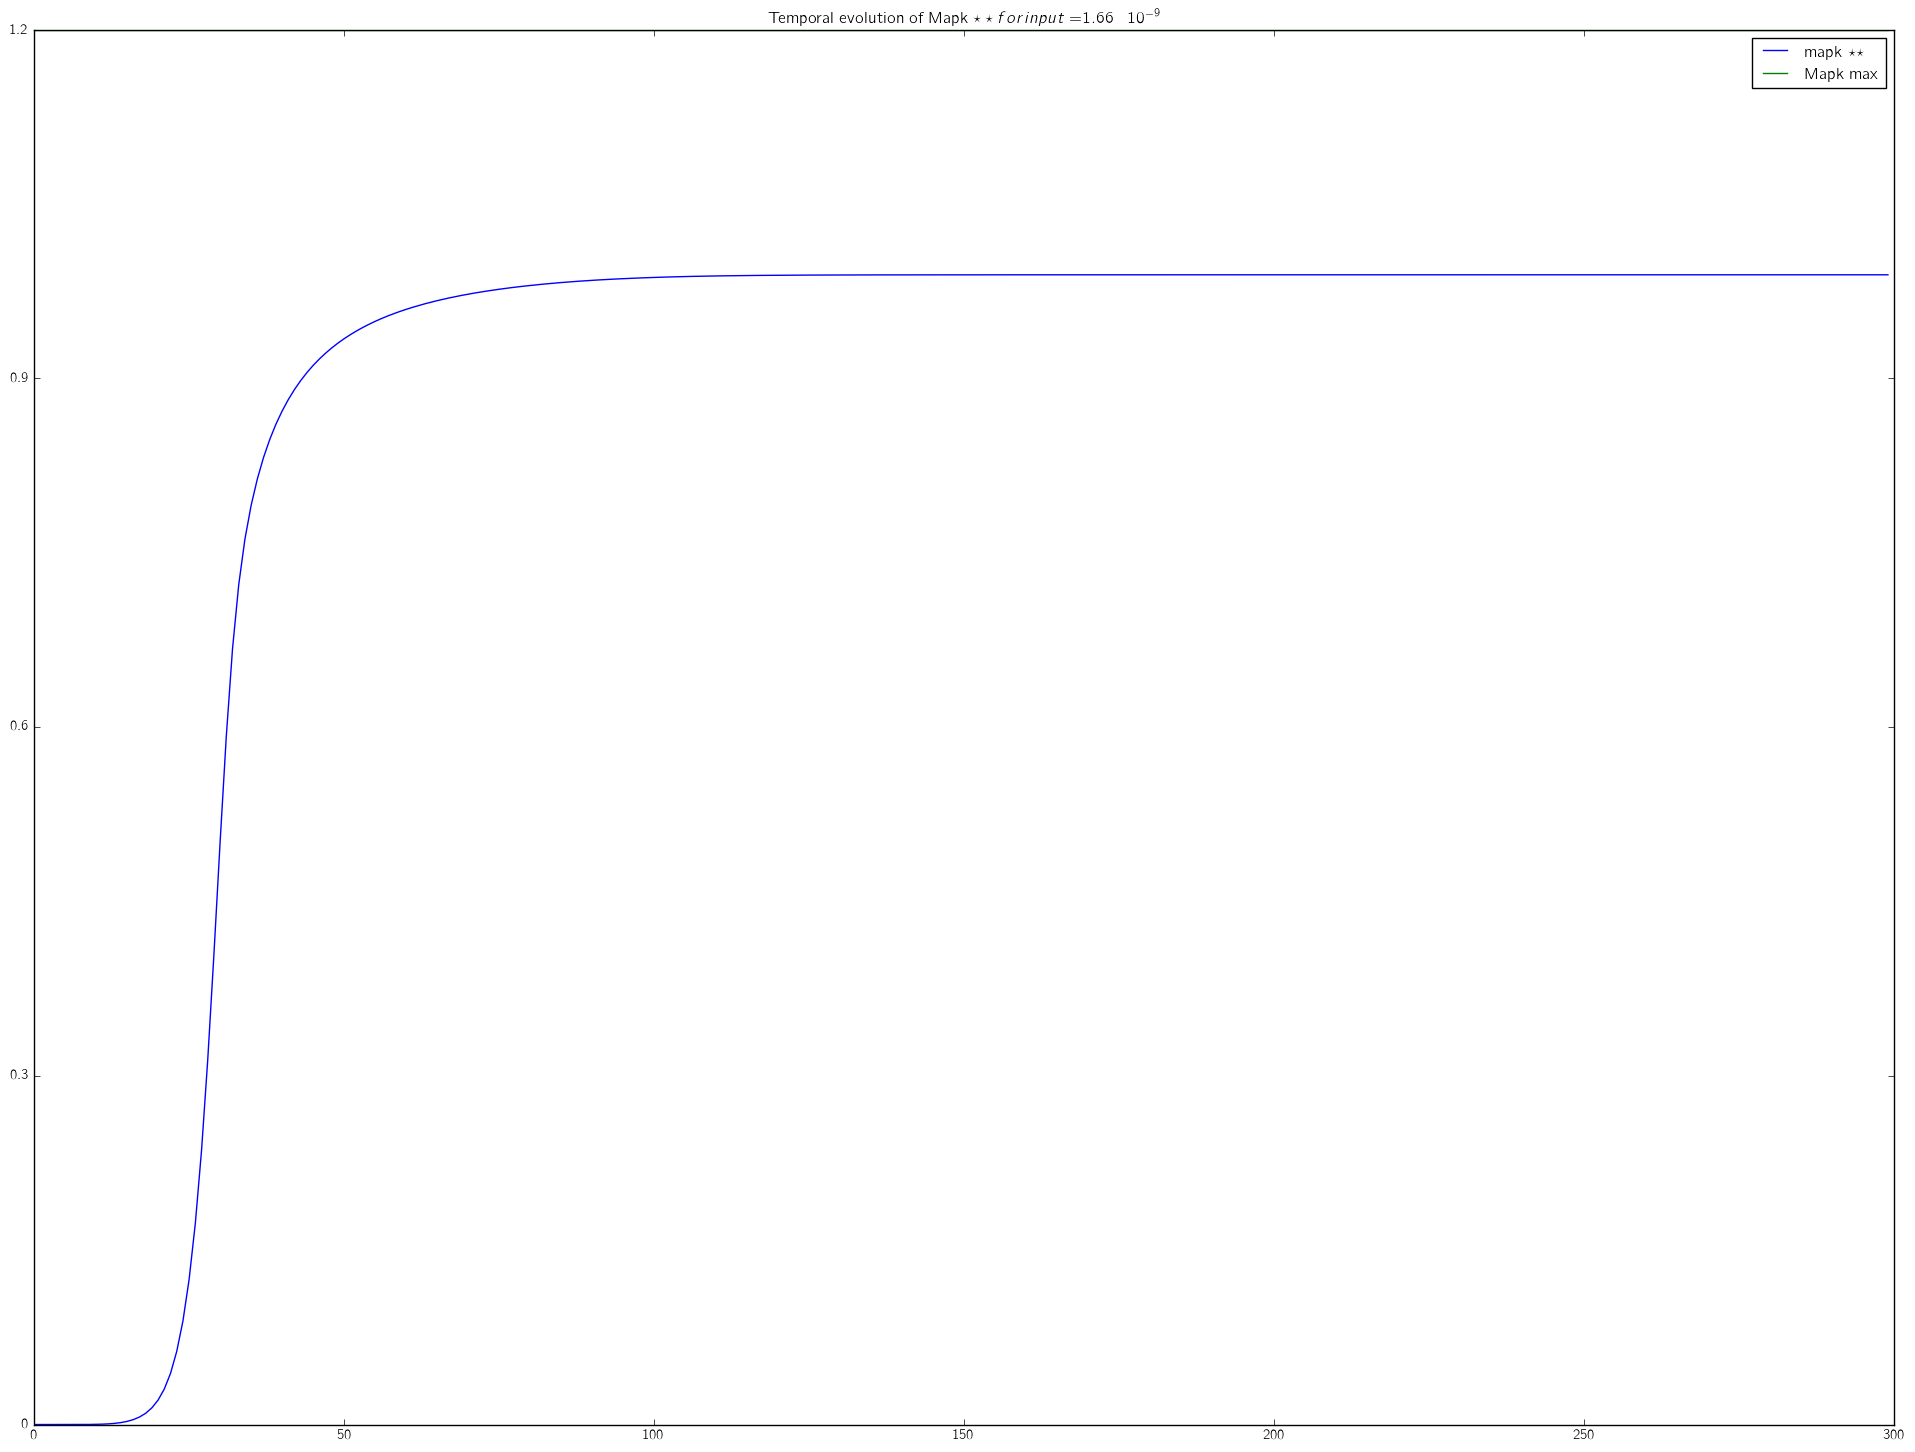

In [56]:
#to number plots    np.arange(1,math.floor(len(range(0,maxn,divmod(maxn,10)[0])))+1)



plotnumber=0

kk=1
param_v[37]=inputlist[kk]
psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))

fig=plt.figure()
plt.plot(psoln[:,15],label=r"$ \textnormal{mapk \star \star}$")
#plot max value of mapk star star
plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
plt.legend()
plt.title(r'Temporal evolution of Mapk \star \star for input = {}'.format(str_fmt(param_v[37],n=2)))
plt.yticks([0, param_v[4]/4, param_v[4]/2, 3*param_v[4]/4, param_v[4]],
['$0$', r'{}'.format(str_fmt(param_v[4]/4)), r'{}'.format(str_fmt(param_v[4]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[4]/4,2))), r'{}'.format(str_fmt(param_v[4]))])

plt.show()
    
#is steady state reached? -- store value. 


RuntimeError: LaTeX was not able to process the following string:
b'$ \\\\textnormal{mapk \\\\star \\\\star}$'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.15 (TeX Live 2014) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./528b703e72ac9d4470f685421722bb89.tex
LaTeX2e <2014/05/01>
Babel <3.9k> and hyphenation patterns for 78 languages loaded.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2014/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucs.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/data/uni-global.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/utf8x.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/cmbright.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/ot1cmbr.fd))
(/usr/local/texlive/2014/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 528b703e72ac9d4470f685421722bb89.aux.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omlcmbrm.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omscmbrs.fd)
! Missing $ inserted.
<inserted text> 
                $
l.13 ...{\sffamily $ \textnormal{mapk \star \star}
                                                  $}
! Extra }, or forgotten $.
\mbox #1->\leavevmode \hbox {#1}
                                
l.13 ...{\sffamily $ \textnormal{mapk \star \star}
                                                  $}
! Extra }, or forgotten $.
\nfss@text #1->{\mbox {#1}}
                           
l.13 ...{\sffamily $ \textnormal{mapk \star \star}
                                                  $}
! Missing $ inserted.
<inserted text> 
                $
l.14 \end{document}
                   
! Missing } inserted.
<inserted text> 
                }
l.14 \end{document}
                   
[1] (./528b703e72ac9d4470f685421722bb89.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 13 ({)
### bottom level
(see the transcript file for additional information)
Output written on 528b703e72ac9d4470f685421722bb89.dvi (1 page, 300 bytes).
Transcript written on 528b703e72ac9d4470f685421722bb89.log.


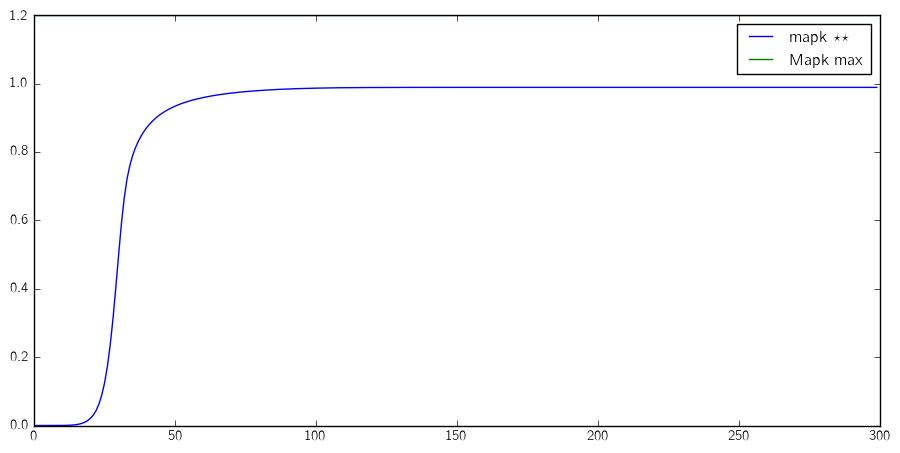

RuntimeError: LaTeX was not able to process the following string:
b'Temporal evolution of Mapk \\\\star \\\\star for input = $1.66 \\\\, 10^{ -9 }$'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.15 (TeX Live 2014) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./6afe5e6be807f828ca142f7feb4e48e4.tex
LaTeX2e <2014/05/01>
Babel <3.9k> and hyphenation patterns for 78 languages loaded.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2014/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucs.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/data/uni-global.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/utf8x.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/cmbright.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/ot1cmbr.fd))
(/usr/local/texlive/2014/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 6afe5e6be807f828ca142f7feb4e48e4.aux.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...\sffamily Temporal evolution of Mapk \star
                                                   \star for input = $1.66 \...

(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omlcmbrm.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omscmbrs.fd)
! Missing $ inserted.
<inserted text> 
                $
l.13 ... Mapk \star \star for input = $1.66 \, 10^
                                                  { -9 }$}
[1] (./6afe5e6be807f828ca142f7feb4e48e4.aux) )
(see the transcript file for additional information)
Output written on 6afe5e6be807f828ca142f7feb4e48e4.dvi (1 page, 480 bytes).
Transcript written on 6afe5e6be807f828ca142f7feb4e48e4.log.


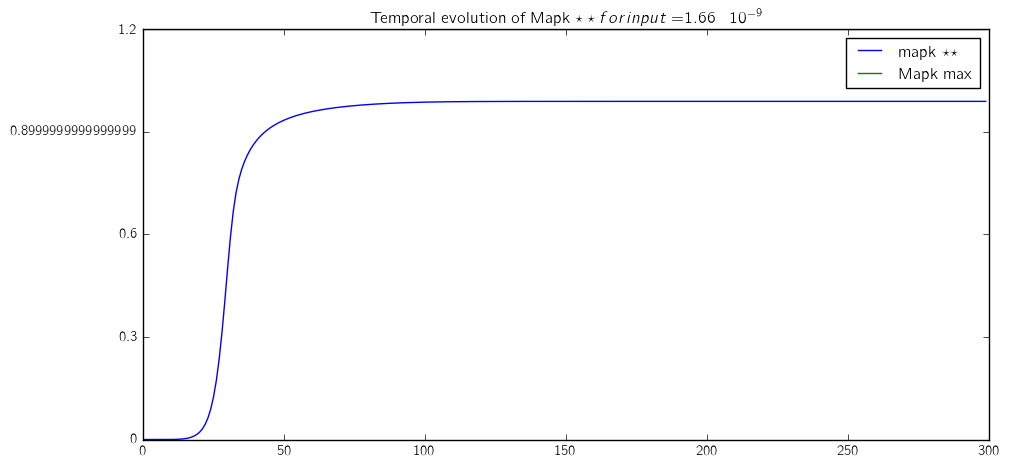

RuntimeError: LaTeX was not able to process the following string:
b'Temporal evolution of Mapk \\\\star \\\\star for input = $4.64 \\\\, 10^{ -7 }$'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.15 (TeX Live 2014) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./78df70e62a6c9b11999473c08a1b492b.tex
LaTeX2e <2014/05/01>
Babel <3.9k> and hyphenation patterns for 78 languages loaded.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2014/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2014/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucs.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/data/uni-global.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/utf8x.def))
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/cmbright.sty
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/ot1cmbr.fd))
(/usr/local/texlive/2014/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2014/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 78df70e62a6c9b11999473c08a1b492b.aux.
(/usr/local/texlive/2014/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/ucs/ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...\sffamily Temporal evolution of Mapk \star
                                                   \star for input = $4.64 \...

(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omlcmbrm.fd)
(/usr/local/texlive/2014/texmf-dist/tex/latex/cmbright/omscmbrs.fd)
! Missing $ inserted.
<inserted text> 
                $
l.13 ... Mapk \star \star for input = $4.64 \, 10^
                                                  { -7 }$}
[1] (./78df70e62a6c9b11999473c08a1b492b.aux) )
(see the transcript file for additional information)
Output written on 78df70e62a6c9b11999473c08a1b492b.dvi (1 page, 480 bytes).
Transcript written on 78df70e62a6c9b11999473c08a1b492b.log.


In [42]:
###################################
    # plot time series & output/input function
    ###################################
    if kk in selectedinput:
        plotnumber=plotnumber+1
        #introduce sub-plots
        plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber)
        plt.rc('text', usetex = True)
        #plot mapk star star time evolution
        plt.plot(psoln[:,15],label=r"$ \textnormal{mapk \star \star}$")
        #plot max value of mapk star star
        plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
        plt.legend()
        plt.title(r'Temporal evolution of Mapk \star \star for input = {}'.format(str_fmt(param_v[37],n=2)))
        plt.yticks([0, param_v[4]/4, param_v[4]/2, 3*param_v[4]/4, param_v[4]],
        ['$0$', r'{}'.format(str_fmt(param_v[4]/4)), r'{}'.format(str_fmt(param_v[4]/2)), r'{}'.format(str_fmt(3*param_v[4]/4)), r'{}'.format(str_fmt(param_v[4]))])

        #is steady state reached?
        #if (rasgtp[(len(rasgtp)-1)]-rasgtp[int(math.floor(.9*(len(rasgtp)-1)))])/WTV<10**(-3)==False:
        #        print("steady state not reached")
        # if yes, keep rasgtp level reached at ss
        storeoutput=np.append(storeoutput,[psoln[:,15][(len(t)-1)]])
        #end on the loop over sos values. 





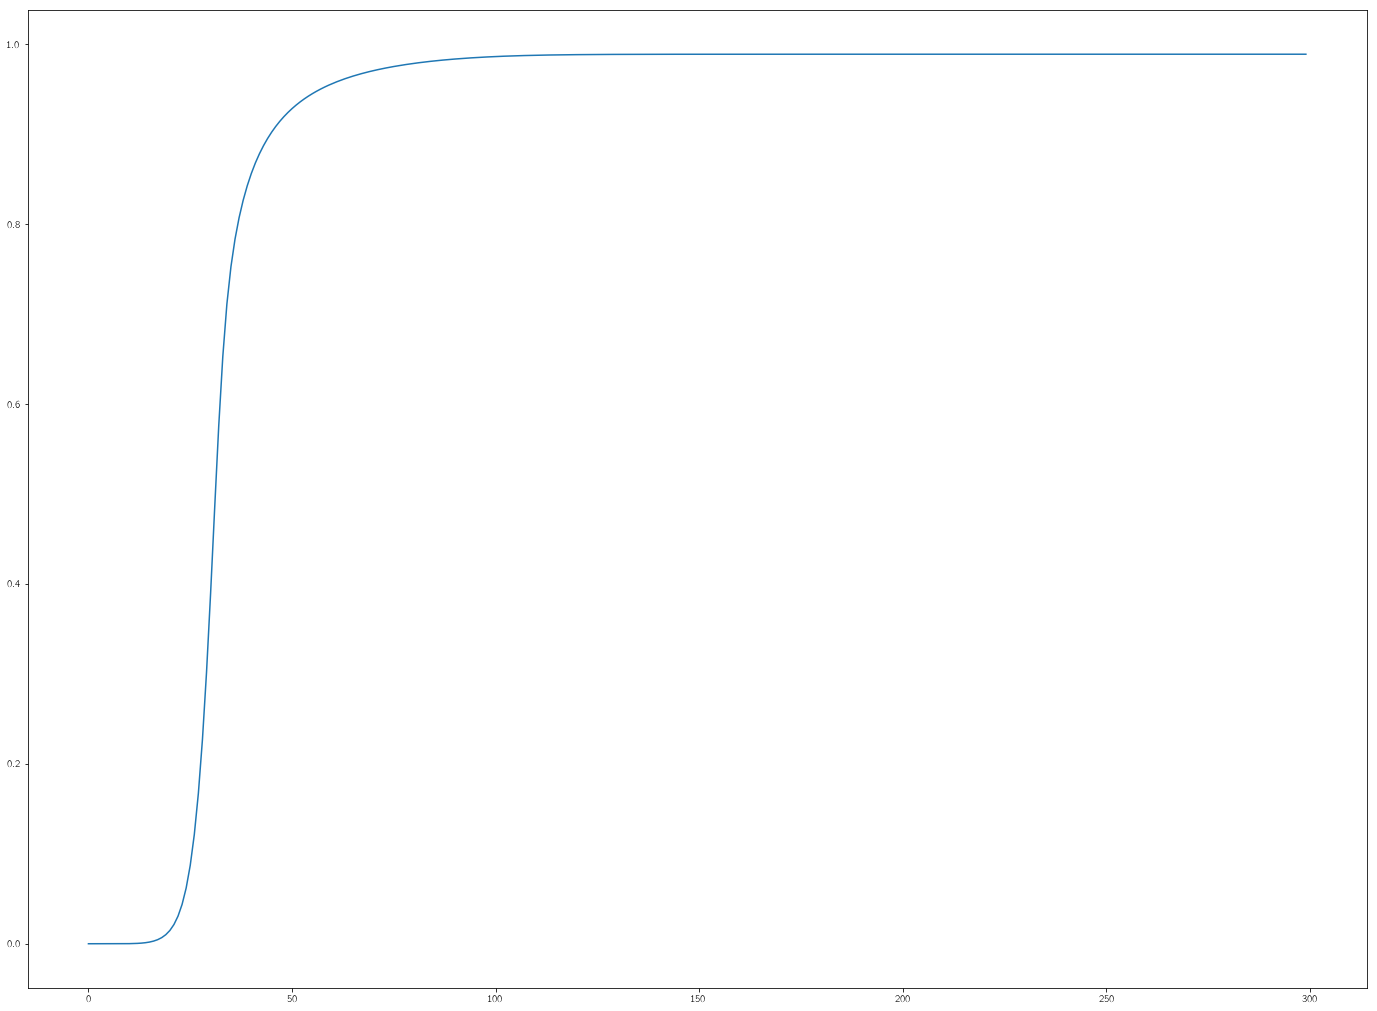

In [63]:
plt.plot(psoln[:,15])
plt.show()

In [70]:
len(params_names)

36